# Stacked Autoencoders

**Autoencoders** are artificial neural networks that learn dense representations of the input data without any supervision. The dense representations are called *latent representations* or *codings*. The codings typically have much lower dimensionality than the input data, which makes autoencoders useful for dimensionality reduction. They can also act as feature detectors (feature extraction), unsupervised pretraining of deep neural networks, and generative models. As generative models, they can randomly generate new data that looks very similar to the training data.

Simply, autoencoders are trained in an unsupervised manner to learn the low-level features of an input (latent representations or codings), which are then used to reconstruct the original input. So, an autoencoder consists of 3 components: encoder, latent representations (or codings), and decoder. The encoder compresses the input and produces the codings. The decoder then reconstructs the input from the codings.

Resources:

https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

https://www.tensorflow.org/tutorials/generative/autoencoder

https://blog.keras.io/building-autoencoders-in-keras.html

https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial

# Import **tensorflow** library

Import library and alias it:

In [1]:
import tensorflow as tf

# GPU Hardware Accelerator

To vastly speed up processing, we can use the GPU available from the Google Colab cloud service. Colab provides a free Tesla K80 GPU of about 12 GB. It’s very easy to enable the GPU in a Colab notebook:

1.	click **Runtime** in the top left menu
2.	click **Change runtime** type from the drop-down menu
3.	choose **GPU** from the Hardware accelerator drop-down menu
4.	click **SAVE**

Verify that GPU is active:

In [2]:
tf.__version__, tf.test.gpu_device_name()

('2.4.1', '/device:GPU:0')

# Stacked Autoencoders

**Stacked encoders** have multiple hidden layers. The architecture is typically symmetrical with regard to the central hidden layer, which is called the *coding layer*. 

## Load Data

Load Fashion-Mnist as Numpy arrays:

In [3]:
import tensorflow_datasets as tfds

(x_train_img, _), (x_test_img, _) = tfds.as_numpy(
    tfds.load('fashion_mnist', split=['train','test'],
              batch_size=-1, as_supervised=True,
              try_gcs=True))

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteTPOF6V/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteTPOF6V/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Notice that we don't load the labels because autoencoders are unsupervised models.

## Scale

Scale by dividing datasets by the number of pixels that represent an image:

In [4]:
import numpy as np

x_train, x_test = x_train_img.astype(np.float32) / 255.,\
                  x_test_img.astype(np.float32) / 255.

## Clear Previous Models and Generate Seed

Clear previous model sessions and generate a seed for reproducibility:

In [5]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

## Get Input Shape

Get input shape for use in the model:

In [6]:
in_shape = x_train.shape[1:]
in_shape

(28, 28, 1)

## Build Stacked Autoencoder

Stacked encoders have multiple hidden layers. The architecture is typically symmetrical with regard to the central hidden layer, which is the coding layer. We split the autoencoder model into the encoder and decoder.

Import libraries:

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,\
  Reshape

In our example, the encoder accepts 28 x 28 pixel grayscale images, flattens them so that each image is represented as a vector of size 784, and processes the vectors through three Dense layers of diminishing sizes (128 units to 64 units to 32 units). The 32 unit layer is the coding layer (central hidden layer). For each input image, the encoder outputs a vector of size 32. 

In [8]:
stacked_encoder = Sequential([
  Flatten(input_shape=in_shape),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(32, activation='relu')
])

The decoder accepts codings of size 32 (output by the encoder) and processes them through three Dense layers of increasing sizes (64 units to 128 units to 784 units). It then reshapes the final vectors into 28 x 28 arrays so the decoder's outputs have the same shape as the encoder's inputs. 

In [9]:
stacked_decoder = Sequential([
  Dense(64, activation='relu'),
  Dense(128, activation='relu'),
  Dense(28 * 28, activation='sigmoid'),
  Reshape(in_shape)
])

## Create Stacked Autoencoder

Create stacked autoencoder based on stacked encoder and decoder:

In [10]:
stacked_ae = Sequential([stacked_encoder, stacked_decoder])

## Create Appropriate Metric

Create metric to track model performance:

In [11]:
def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(tf.round(y_true),
                                            tf.round(y_pred))

The *accuracy* metric won't work properly since it expects labels to be either 0 or 1 for each pixel.

## Compile

Use **binary crossentropy** as the loss function because the reconstruction task is a multilabel binary classification problem since each pixel intensity represents the probability that the pixel should be black.

In [12]:
opt = tf.keras.optimizers.SGD(lr=1.5)

stacked_ae.compile(
    loss='binary_crossentropy',
    optimizer=opt, metrics=[rounded_accuracy])

## Train

Train the model using x_train as both the input and the target. The encoder will learn to compress the dataset from 784 dimensions to the latent space, and the decoder will learn to reconstruct the original images.

In [13]:
sae_history = stacked_ae.fit(
    x_train, x_train, epochs=10,
    validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4370 - rounded_accuracy: 0.7862 - val_loss: 0.3243 - val_rounded_accuracy: 0.9001
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3212 - rounded_accuracy: 0.8996 - val_loss: 0.3129 - val_rounded_accuracy: 0.9064
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3100 - rounded_accuracy: 0.9102 - val_loss: 0.3068 - val_rounded_accuracy: 0.9115
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3039 - rounded_accuracy: 0.9149 - val_loss: 0.3058 - val_rounded_accuracy: 0.9081
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3003 - rounded_accuracy: 0.9178 - val_loss: 0.2995 - val_rounded_accuracy: 0.9170
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2976 - rounded_accuracy: 0.9203 - val_loss: 0.2980 - val_rounded_accuracy: 0.9228
Epoch 7/10
1875/1875 [==================

## Visualize Performance

Import a plotting library:

In [14]:
import matplotlib.pyplot as plt

Create a visualization function:

In [15]:
def viz_history(training_history):
  loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']
  accuracy = training_history.history['rounded_accuracy']
  val_accuracy = training_history.history['val_rounded_accuracy']
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(loss, label='Training set')
  plt.plot(val_loss, label='Test set', linestyle='--')
  plt.legend()
  plt.grid(linestyle='--', linewidth=1, alpha=0.5)
  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(accuracy, label='Training set')
  plt.plot(val_accuracy, label='Test set', linestyle='--')
  plt.legend()
  plt.grid(linestyle='--', linewidth=1, alpha=0.5)
  plt.show()

Visualize:

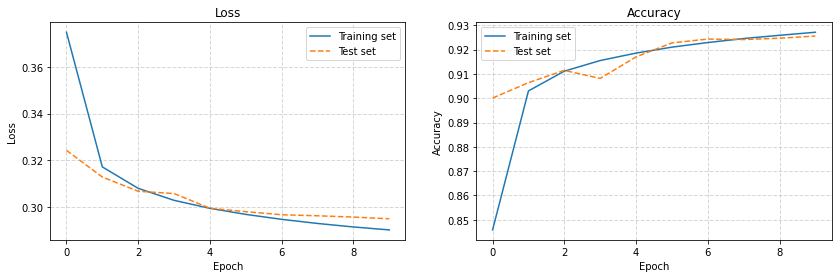

In [33]:
viz_history(sae_history)

## Visualize the Reconstructions

Create a function to plot a grayscale 28x28 image:

In [34]:
import matplotlib.pyplot as plt

def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

Create a function to visualize original images and reconstructions:

In [35]:
def show_reconstructions(model, images, n_images):
  reconstructions = model.predict(images[:n_images])
  reconstructions = tf.squeeze(reconstructions) # drop '1' dimension
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

The predict() function adds the *1* dimension back.

Check dimensionality of test data:

In [36]:
x_test.shape

(10000, 28, 28, 1)

To visualize with imshow(), we must remove dimensions of size 1 from the shape of a tensor:

In [37]:
x_test_imgs = tf.squeeze(x_test)
x_test_imgs.shape

TensorShape([10000, 28, 28])

Visualize:

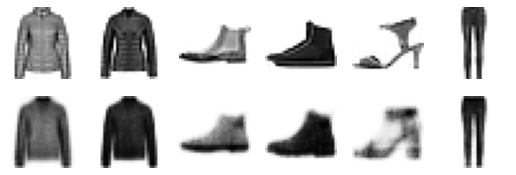

In [38]:
show_reconstructions(stacked_ae, x_test_imgs, 6)

Reconstructed images are generated from **test images** based on predictions from the trained model.

## Breakdown

Grab an image from the test set:

In [39]:
img = x_test[:1]

Since the prediction method computations are done in batches, we grab the first image as a batch of one.

Make a prediction based on the image batch:

In [40]:
reconstruction = stacked_ae.predict(img)

Drop the '1' dimension:

In [41]:
reconstruction = tf.squeeze(reconstruction)

Plot reconstruction:

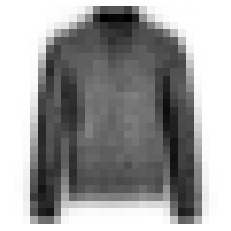

In [42]:
plot_image(reconstruction)

Plot actual image:

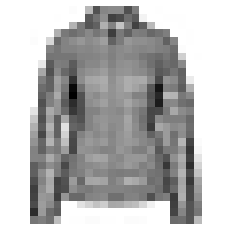

In [43]:
plot_image(tf.squeeze(x_test[0]))

We squeeze out the '1' dimension from the image to plot.

## Visualize with Dimensionality Reduction

To perform dimensionality reduction, we need labels. So load labels from the **test data** set:

In [44]:
test = tfds.as_numpy(
    tfds.load('fashion_mnist', split=['test'],
              batch_size=-1, as_supervised=True,
              try_gcs=True))

Slice test labels from the test data set:

In [45]:
y_test = test[0][1]

Use the encoder to reduce dimensionality to 32:

In [29]:
from sklearn.manifold import TSNE

np.random.seed(0)
x_test_compressed = stacked_encoder.predict(x_test_imgs)
tsne = TSNE()
x_test_2D = tsne.fit_transform(x_test_compressed)
x_test_2D = (x_test_2D - x_test_2D.min()) /\
  (x_test_2D.max() - x_test_2D.min())

We used Scikit-Learn's implementation of the t-SNE algorithm to reduce dimensionality to 2D for visualization.

Visualize:

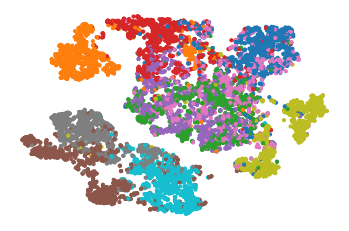

In [46]:
plt.scatter(x_test_2D[:, 0], x_test_2D[:, 1],
            c=y_test, s=10, cmap='tab10')
plt.axis('off')
plt.show()

Each class is represented by a different color.

Display a prettier visualization:

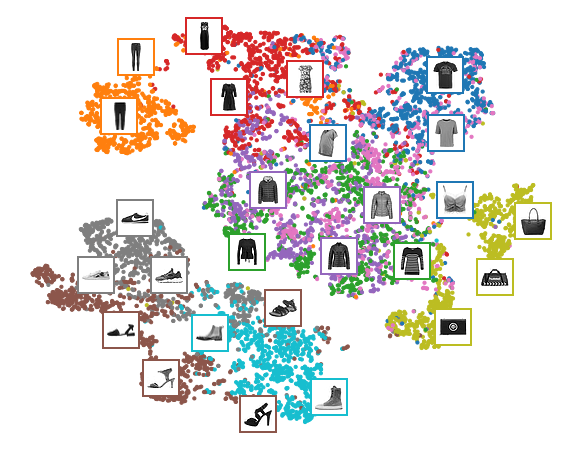

In [47]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(x_test_2D[:, 0], x_test_2D[:, 1],
            c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(x_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test_imgs[index],
                                      cmap='binary'),
            position, bboxprops={
                'edgecolor': cmap(y_test[index]), 'lw': 2})
        plt.gca().add_artist(imagebox)
plt.axis('off')
plt.show()

Adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

# Tying Weights

When an autoencoder is neatly symmetrical, we can tie the weights of the decoder layers to the weights of the encoder layers. As a result, we halve the number of weights in the model, which speeds training and reduces overfitting. 

## Define a Custom Layer

To tie the weights of the encoder and the decoder, we use the transpose of the encoder's weights as the decoder weights:

In [48]:
class DenseTranspose(tf.keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = tf.keras.activations.get(activation)
    super().__init__(**kwargs)
  def build(self, batch_input_shape):
    self.biases = self.add_weight(
        name='bias', shape=[self.dense.input_shape[-1]],
        initializer='zeros')
    super().build(batch_input_shape)
  def call(self, inputs):
    z = tf.matmul(
        inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

The class accepts a layer from a model, an activation function (if included in a layer), and transposes the data. A lot of times we have to preprocess data fed into machine learning algorithms. The reason is that data may be stored as rows, but the machine learning algorithm expects input as columns or vice versa. So transposition is a very useful operation in machine learning.

Resource:

https://www.youtube.com/watch?v=QDpeRUIrb6U

## Clear Models and Generate Seed

Clear previous model sessions and generate a seed for reproducibility:

In [49]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

## Create Dense Layers

Create three dense layers for the model:

In [50]:
dense_1 = Dense(128, activation='relu')
dense_2 = Dense(64, activation='relu')
dense_3 = Dense(32, activation='relu')

## Build the Encoder

Build the encoder with three dense layers:

In [51]:
tied_encoder = Sequential([
  Flatten(input_shape=in_shape),
  dense_1,
  dense_2,
  dense_3
])

## Build the Decoder

Build the decoder and tie weights with the encoder:

In [52]:
tied_decoder = Sequential([
  DenseTranspose(dense_3, activation='relu'),
  DenseTranspose(dense_2, activation='relu'),
  DenseTranspose(dense_1, activation='sigmoid'),
  Reshape([28, 28])
])

## Build Tied Model

Build the model with tied weights between the encoder and decoder:

In [53]:
tied_ae = Sequential([tied_encoder, tied_decoder])

## Compile

Compile with **binary crossentropy**:

In [54]:
tied_ae.compile(loss='binary_crossentropy',
                optimizer=opt, metrics=[rounded_accuracy])

## Train

Train for ten epochs:

In [55]:
tied_history = tied_ae.fit(
    x_train, x_train, epochs=10,
    validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3983 - rounded_accuracy: 0.8241 - val_loss: 0.3145 - val_rounded_accuracy: 0.9090
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3104 - rounded_accuracy: 0.9089 - val_loss: 0.3020 - val_rounded_accuracy: 0.9171
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3013 - rounded_accuracy: 0.9179 - val_loss: 0.2965 - val_rounded_accuracy: 0.9220
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2962 - rounded_accuracy: 0.9220 - val_loss: 0.2985 - val_rounded_accuracy: 0.9163
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2930 - rounded_accuracy: 0.9243 - val_loss: 0.2926 - val_rounded_accuracy: 0.9280
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2912 - rounded_accuracy: 0.9261 - val_loss: 0.2901 - val_rounded_accuracy: 0.9295
Epoch 7/10
1875/1875 [==================

Visualize training performance:

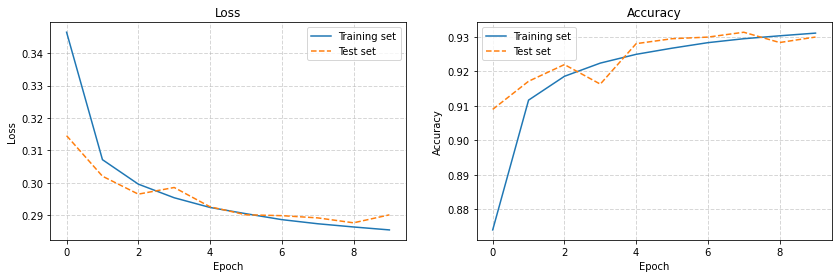

In [56]:
viz_history(tied_history)

## Visualize Reconstructions

Show test image reconstructions based on predictions from the trained model:

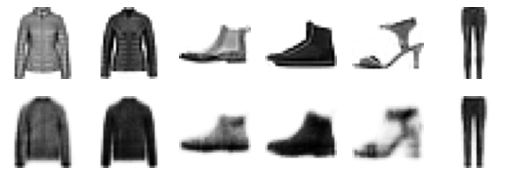

In [61]:
show_reconstructions(tied_ae, x_test_imgs, 6)
plt.show()

# Denoising Autoencoders

An autoencoder can also be trained to remove noise from images. We can add noise to inputs and train to recover the original noise-free inputs.

## Clear Model and Generate Seed

Clear previous model sessions and generate a seed for reproducibility:

In [62]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

## Build the Encoder with Gaussian Noise

Add pure Gaussian noise directly in the encoder:

In [63]:
from tensorflow.keras.layers import GaussianNoise

gaussian_encoder = Sequential([
  Flatten(input_shape=in_shape),
  GaussianNoise(0.2),
  dense_1,
  dense_2,
  dense_3
])

## Build the Decoder

Tie the weights of the decoder layers to the weights of the encoder layers:

In [64]:
gaussian_decoder = Sequential([
  DenseTranspose(dense_3, activation='relu'),
  DenseTranspose(dense_2, activation='relu'),
  DenseTranspose(dense_1, activation='sigmoid'),
  Reshape([28, 28])
])

## Build the Denoising Autoencoder

Build the denoising autoencoder from the gaussian encoder and decoder:

In [65]:
gaussian_ae = Sequential([gaussian_encoder, gaussian_decoder])

## Compile

Compile with **binary crossentropy**:

In [66]:
gaussian_ae.compile(
    loss='binary_crossentropy',
    optimizer=opt, metrics=[rounded_accuracy])

## Train

Train model for ten epochs:

In [67]:
gae_history = gaussian_ae.fit(
    x_train, x_train, epochs=10,
    validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2897 - rounded_accuracy: 0.9268 - val_loss: 0.2858 - val_rounded_accuracy: 0.9336
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2888 - rounded_accuracy: 0.9284 - val_loss: 0.2850 - val_rounded_accuracy: 0.9332
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2881 - rounded_accuracy: 0.9296 - val_loss: 0.2857 - val_rounded_accuracy: 0.9326
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2870 - rounded_accuracy: 0.9301 - val_loss: 0.2888 - val_rounded_accuracy: 0.9243
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2866 - rounded_accuracy: 0.9302 - val_loss: 0.2841 - val_rounded_accuracy: 0.9361
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2862 - rounded_accuracy: 0.9307 - val_loss: 0.2848 - val_rounded_accuracy: 0.9321
Epoch 7/10
1875/1875 [==================

Visualize training performance:

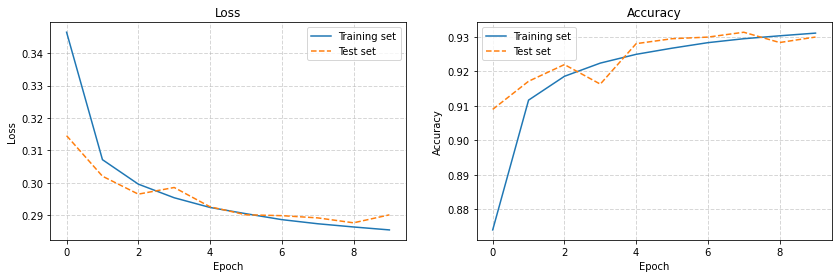

In [68]:
viz_history(tied_history)

## Visualize Reconstructions

Add the same amount of Gaussian noise to **test** images:

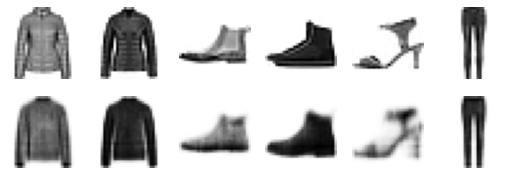

In [69]:
noise = GaussianNoise(0.2)
show_reconstructions(gaussian_ae, noise(x_test_imgs), 6)
plt.show()

# Build the Encoder with Dropout

Add dropout directly into the encoder. Dropout adds random noise to the images.

In [77]:
from tensorflow.keras.layers import Dropout

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

dropout_encoder = Sequential([
  Flatten(input_shape=in_shape),
  Dropout(0.5),
  dense_1,
  dense_2,
  dense_3
])

## Build the Decoder

Tie the weights of the decoder layers to the weights of the encoder layers:

In [78]:
dropout_decoder = Sequential([
  DenseTranspose(dense_3, activation='relu'),
  DenseTranspose(dense_2, activation='relu'),
  DenseTranspose(dense_1, activation='sigmoid'),
  Reshape([28, 28])
])

We tie the weights together because the performance is better.

## Build the Dropout Autoencoder

Build the autoencoder from the dropout encoder and decoder:

In [79]:
dropout_ae = Sequential([dropout_encoder, dropout_decoder])

## Compile

Compile with **binary crossentropy**:

In [80]:
dropout_ae.compile(
    loss='binary_crossentropy',
    optimizer=opt, metrics=[rounded_accuracy])

## Train

Train the model for ten epochs:

In [74]:
drop_history = dropout_ae.fit(
    x_train, x_train, epochs=10,
    validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2907 - rounded_accuracy: 0.9251 - val_loss: 0.2851 - val_rounded_accuracy: 0.9339
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2902 - rounded_accuracy: 0.9261 - val_loss: 0.2857 - val_rounded_accuracy: 0.9334
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2898 - rounded_accuracy: 0.9267 - val_loss: 0.2842 - val_rounded_accuracy: 0.9339
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2889 - rounded_accuracy: 0.9268 - val_loss: 0.2841 - val_rounded_accuracy: 0.9338
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2887 - rounded_accuracy: 0.9268 - val_loss: 0.2837 - val_rounded_accuracy: 0.9342
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2885 - rounded_accuracy: 0.9272 - val_loss: 0.2839 - val_rounded_accuracy: 0.9337
Epoch 7/10
1875/1875 [==================

Visualize performance:

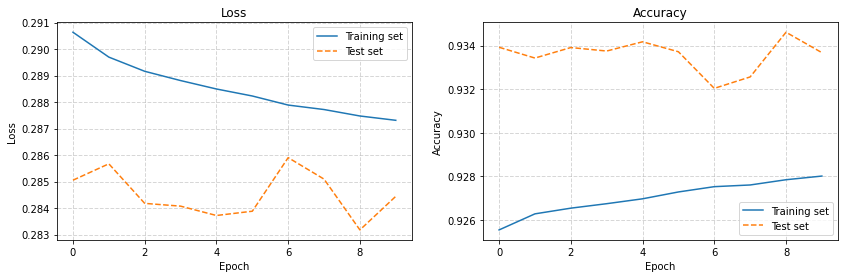

In [81]:
viz_history(drop_history)

## Visualize Reconstructions

Add the same amount of dropout noise to test images:

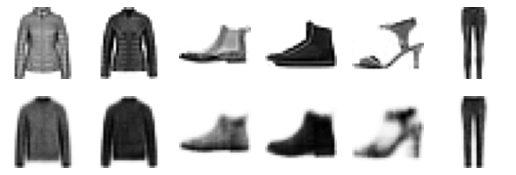

In [82]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

dropout = Dropout(0.5)
show_reconstructions(dropout_ae, dropout(x_test_imgs), 6)
plt.show()